# Blood cells detection using deep learning 

In [1]:
# importing the necessary libraries 

import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from keras import applications
import numpy as np 

In [2]:
# getting the train and test data from the local folder 

train_data_dir = "D:\\AIML SEM 5\\blood data\\dataset2-master\\dataset2-master\\images\\TRAIN"
test_data_dir = "D:\\AIML SEM 5\\blood data\\dataset2-master\\dataset2-master\\images\\TEST"

In [3]:
# using image datagenerator for augmentation purpose 

datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
#     preprocessing_function = myFunc
    )

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split = 0.1,
#     preprocessing_function = myFunc
    )

In [5]:
# defining the train , validation and test dataset for model building 

train_data = train_datagen.flow_from_directory(train_data_dir,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(150, 150),
                                                    seed = 30,
                                               subset = 'training')
valid_data = train_datagen.flow_from_directory(train_data_dir,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(150, 150),
                                                    seed = 32,
                                               subset = 'validation')
test_data= datagen.flow_from_directory(test_data_dir, 
                                                   shuffle=False, 
                                                   batch_size=32, 
                                                   class_mode='categorical', 
                                                   target_size=(150, 150),
                                                    seed = 30)


Found 8964 images belonging to 4 classes.
Found 993 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [6]:
train_data.labels

array([0, 0, 0, ..., 3, 3, 3])

In [8]:
np.unique(train_data.classes)

array([0, 1, 2, 3])

(32, 150, 150, 3)


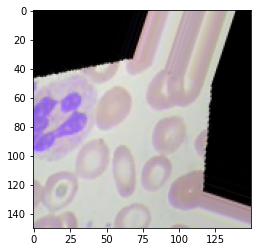

(32, 150, 150, 3)


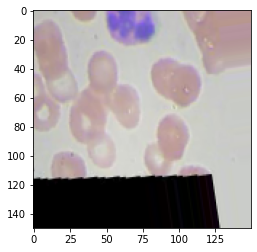

(32, 150, 150, 3)


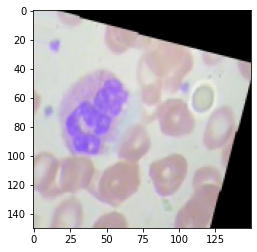

(32, 150, 150, 3)


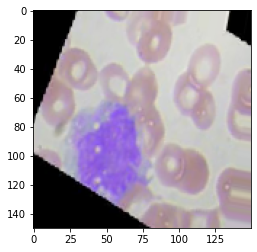

(32, 150, 150, 3)


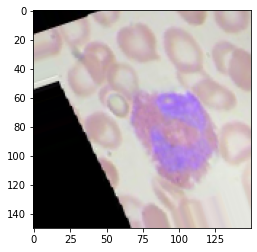

In [10]:
# randomly plotting the images 

for _ in range(5):
    img, label = train_data.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

In [13]:
# defining a function for ploting the loss curves

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


In [14]:
from keras.layers import Flatten , Dense

In [15]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

In [16]:
# confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=20, norm=False, savefig=False): 


  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=90, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [17]:
# giving index values for the classes 

class_names = test_data.class_indices
class_names

{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}

In [18]:
# building fine tuning - transfer learning model using vgg16

base_model = tf.keras.applications.vgg16.VGG16(pooling = 'avg' , include_top=False,input_shape=(150, 150, 3), weights='imagenet')
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# model = data_augmentation(inputs)

inputs = base_model.input
x = tf.keras.layers.Dense(128,activation = 'relu')(base_model.output)


outputs = tf.keras.layers.Dense(4 , activation = "softmax", name="op_layer")(x)

main_model = tf.keras.Model(inputs , outputs)

In [19]:
# compiling the model

main_model.compile(loss ="categorical_crossentropy",
                  optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0001),
                  metrics = ["accuracy"])

In [20]:
# itierating the model for initial 5 epochs 

initial_epoch = 5
history_main_model = main_model.fit(train_data,
                                   epochs = initial_epoch,
                                   steps_per_epoch = len(train_data),
                                   validation_data= valid_data,
                                    validation_steps = len(valid_data),
                                   callbacks = [tf.keras.callbacks.EarlyStopping(
                                                monitor = 'val_loss' , 
                                                patience = 5,
                                                restore_best_weights = True
                                               )])

Epoch 1/5
281/281 [==============================] - 1068s 4s/step - loss: 0.7521 - accuracy: 0.6749 - val_loss: 0.3967 - val_accuracy: 0.8248
Epoch 2/5
281/281 [==============================] - 1035s 4s/step - loss: 0.3107 - accuracy: 0.8821 - val_loss: 1.6680 - val_accuracy: 0.7170
Epoch 3/5
281/281 [==============================] - 1040s 4s/step - loss: 0.2558 - accuracy: 0.9141 - val_loss: 0.1408 - val_accuracy: 0.9376
Epoch 4/5
281/281 [==============================] - 1039s 4s/step - loss: 0.2139 - accuracy: 0.9307 - val_loss: 0.1381 - val_accuracy: 0.9537
Epoch 5/5
281/281 [==============================] - 1006s 4s/step - loss: 0.2341 - accuracy: 0.9290 - val_loss: 0.1052 - val_accuracy: 0.9637


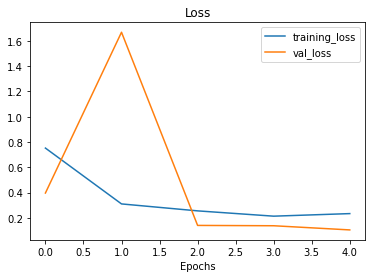

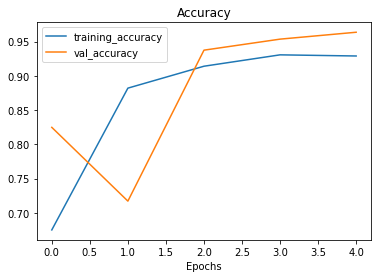

In [21]:
plot_loss_curves(history_main_model)

In [22]:
# evaluating the model on test data

evaluation = main_model.evaluate(test_data)
evaluation 

78/78 [==============================] - 140s 2s/step - loss: 0.7738 - accuracy: 0.8347


[0.7738133668899536, 0.8347406387329102]

In [23]:
# predicting the test data values

pred_prob = main_model.predict(test_data , verbose = 1)

78/78 [==============================] - 141s 2s/step


In [24]:
len(pred_prob)

2487

In [25]:
pred_prob[:10]

array([[9.2191195e-01, 9.5064956e-04, 4.0813416e-04, 7.6729253e-02],
       [7.6622206e-01, 4.6196187e-06, 2.2931033e-04, 2.3354405e-01],
       [9.0979457e-01, 7.3548337e-03, 1.7217001e-04, 8.2678527e-02],
       [1.9852605e-01, 5.7614956e-04, 1.7467713e-02, 7.8343004e-01],
       [8.6511362e-01, 6.2563747e-02, 8.0113714e-06, 7.2314598e-02],
       [9.8410875e-01, 4.0821612e-04, 4.0443894e-05, 1.5442551e-02],
       [1.0000000e+00, 8.6547376e-13, 1.2510395e-10, 1.0111971e-08],
       [1.0000000e+00, 4.9276936e-16, 7.7687623e-13, 8.8683741e-11],
       [9.9652880e-01, 4.5830698e-06, 8.9781288e-08, 3.4664664e-03],
       [4.2609072e-01, 3.4788781e-04, 2.3465090e-04, 5.7332671e-01]],
      dtype=float32)

In [26]:
pred_classes = pred_prob.argmax(axis=1)

pred_classes[:10]

array([0, 0, 0, 3, 0, 0, 0, 0, 0, 3], dtype=int64)

In [27]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

In [28]:
test_data.labels

array([0, 0, 0, ..., 3, 3, 3])

In [29]:
# calculating the accuracy value for the test data

acc = accuracy_score(test_data.labels, pred_classes)

In [30]:
acc

0.8299155609167672

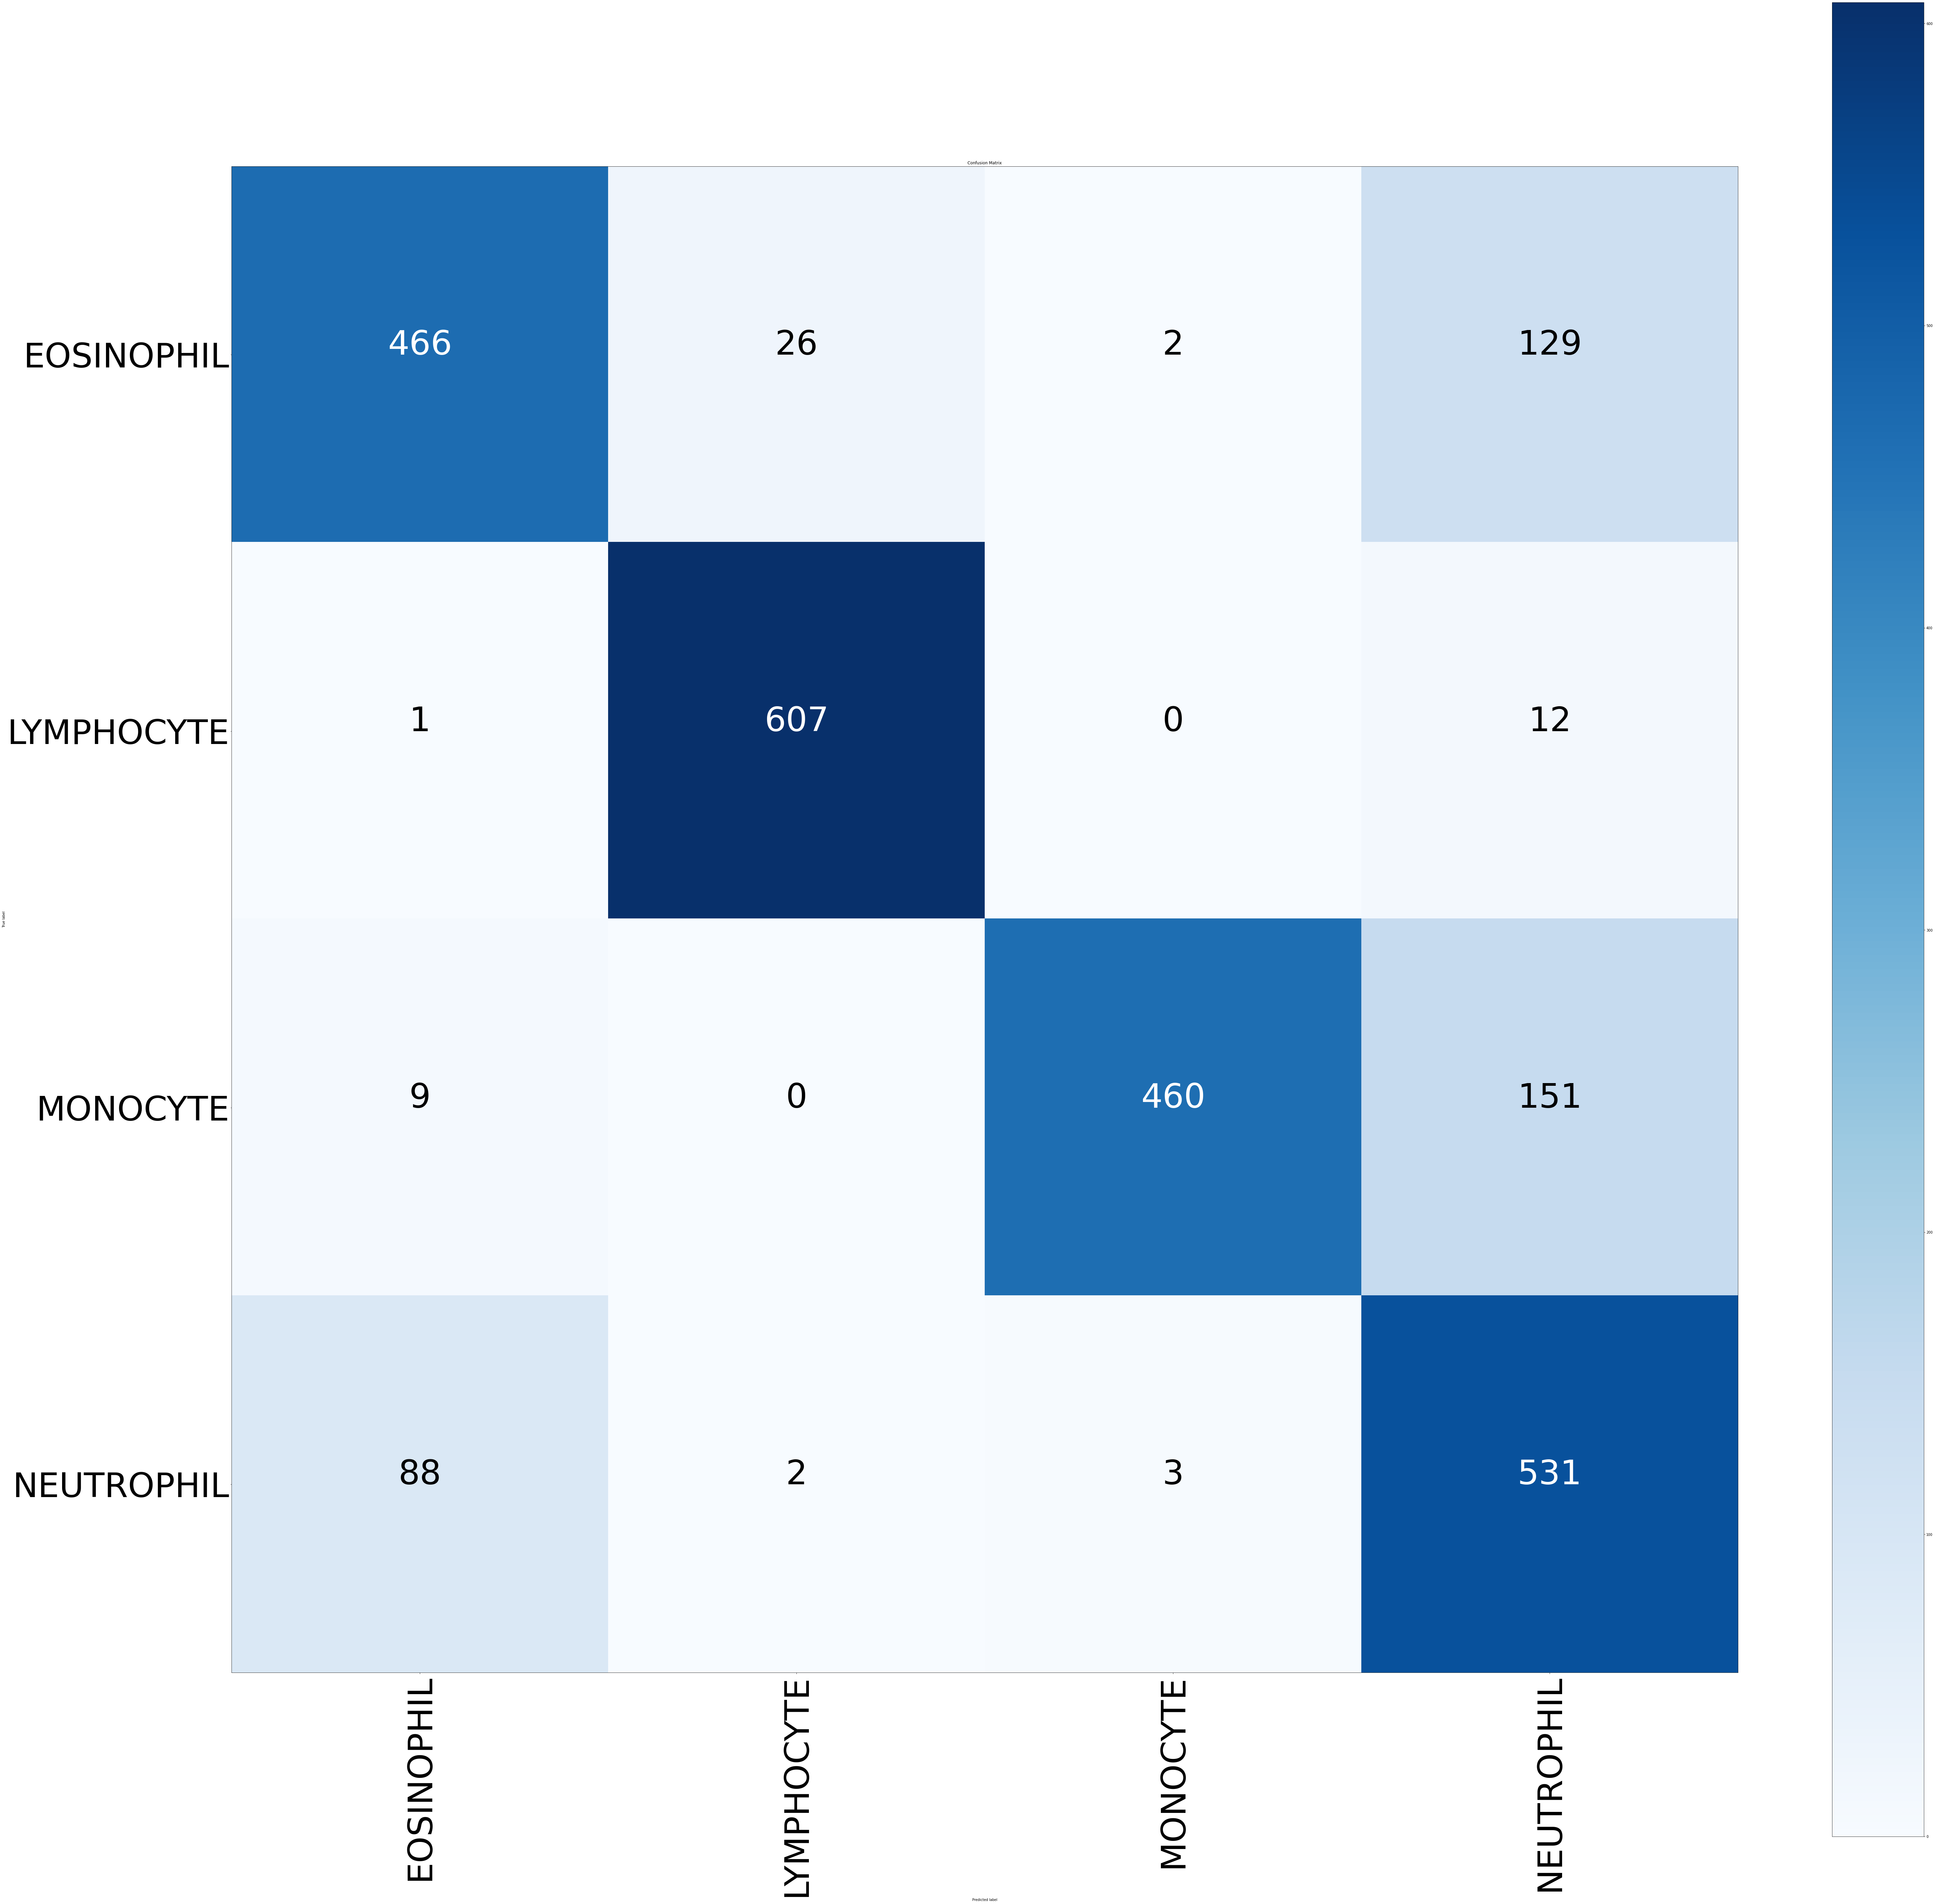

In [31]:
# plotting confusion matrix for the test data prediction 

make_confusion_matrix(y_true=test_data.labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=100,
                      norm=False,
                      savefig=True)